In [17]:
import pandas as pd
import numpy as np

import glob
import os

import tqdm
import sys

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [5]:
DATA_DIR = "../x_dataset/*"

In [18]:
!{sys.executable} -m pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [16]:
def populate_date(df):
    if('timestamp' in df.columns):
        df.drop(['timestamp'],axis=1,inplace=True)
    if('epoch_dt' in df.columns):
        df.drop(['epoch_dt'],axis=1,inplace=True)
        
    if("type" not in df.columns):
        df["type"] = "tweet-"
        
    df = df[pd.to_numeric(df['epoch'], errors='coerce').notna()]  # Remove non-numeric values
    df['epoch'] = df['epoch'].astype(float)
    df['date'] = pd.to_datetime(df['epoch'], unit='s',errors='coerce').dt.date

    act = df.shape[0]
    df.dropna(subset='date',inplace=True)
    final  = df.shape[0]
    
    return df,(act,final)

def process_chunk(df):
    actual_size = df.shape[0]
    df = df[df['type'] != '.']
    df_good = df[~df['type'].str.contains('https://')]
    df_good = df_good[pd.to_numeric(df_good['epoch'], errors='coerce').notna()]  # Remove non-numeric values
    df_good['epoch'] = df_good['epoch'].astype(float)
    df_good['date'] = pd.to_datetime(df_good['epoch'], unit='s',errors='coerce').dt.date
    df_good.dropna(subset=['date'],inplace=True)
    
    df_bad = df[df['type'].str.contains('https://')]
    df_bad['text'] = df_bad['type']
    df_bad['type'] = 'ad_tweet'

    df_f = pd.concat([df_good,df_bad])
    df_f = df_f[df_f['type'].str.contains('tweet')]

    del df_good
    del df_bad
    del df

    final_size = df_f.shape[0]
    
    return df_f,(actual_size,final_size)

In [17]:
pbar = tqdm.tqdm(range(30,39),desc='progress')
sizes_dict = {}
for part_inx in pbar:
    pbar.set_description(f'Currently Processing {part_inx}')
    chunks = glob.glob(f'../usc-x-24-us-election/part_{part_inx}/*.csv.gz')
    for chunk in chunks:
        chunk_df = pd.read_csv(chunk,compression='gzip')
        chunk_df_processed,time_tup = process_chunk(chunk_df)
        chunk_df_processed.to_csv(chunk,compression='gzip')
        sizes_dict[f'{part_inx}_chunk_{chunk}'] = {'initial_size':time_tup[0],'final_size':time_tup[1]}
    pbar.set_description(f'Completed {part_inx}')

Completed 38: 100%|██████████| 9/9 [11:41<00:00, 77.95s/it]            


In [14]:
pbar = tqdm.tqdm(range(1,30),desc='progress')
counts =0
for part_inx in pbar:
    # pbar.set_description(f'Currently Processing {part_inx}')
    chunks = glob.glob(f'../usc-x-24-us-election/part_{part_inx}/*.csv.gz')
    for chunk in chunks:
        chunk_df = pd.read_csv(chunk,compression='gzip')
        counts += chunk_df[chunk_df['date'] == '2024-07-14'].shape[0]
    # pbar.set_description(f'Completed {part_inx}')

progress: 100%|██████████| 29/29 [09:14<00:00, 19.12s/it]


In [15]:
print(counts)

1068235


In [19]:
df = pd.read_csv('../usc-x-24-us-election/part_38/october_chunk_23.csv.gz',compression='gzip')

In [20]:
df['date'].unique()

array(['2024-10-30', '2024-10-28', '2024-10-09', '2024-10-10'],
      dtype=object)

In [8]:

import glob
import os

In [13]:
root_dir = '../usc-x-24-us-election/'
print(os.listdir(root_dir))

['part_14', 'part_26', 'part_8', 'part_2', 'part_42', 'part_35', 'part_32', 'part_38', 'part_5', 'part_21', '.git', 'part_19', 'part_13', 'part_17', 'part_25', 'part_41', 'part_1', 'part_6', 'part_31', 'part_22', 'part_28', 'part_10', 'part_20', 'part_12', 'part_18', 'part_39', 'part_44', 'part_33', 'part_4', 'part_3', 'part_9', 'part_34', 'part_43', 'part_15', 'part_27', 'part_29', 'part_23', 'part_11', 'part_7', 'part_30', 'README.md', 'part_40', 'part_37', 'part_16', 'part_24']


Completed for part ../usc-x-24-us-election/part_24/aug_chunk_36.csv.gz: 100%|██████████| 45/45 [23:25<00:00, 31.24s/it]       
/tmp/SLURM_397155/ipykernel_2815647/3817654750.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis")


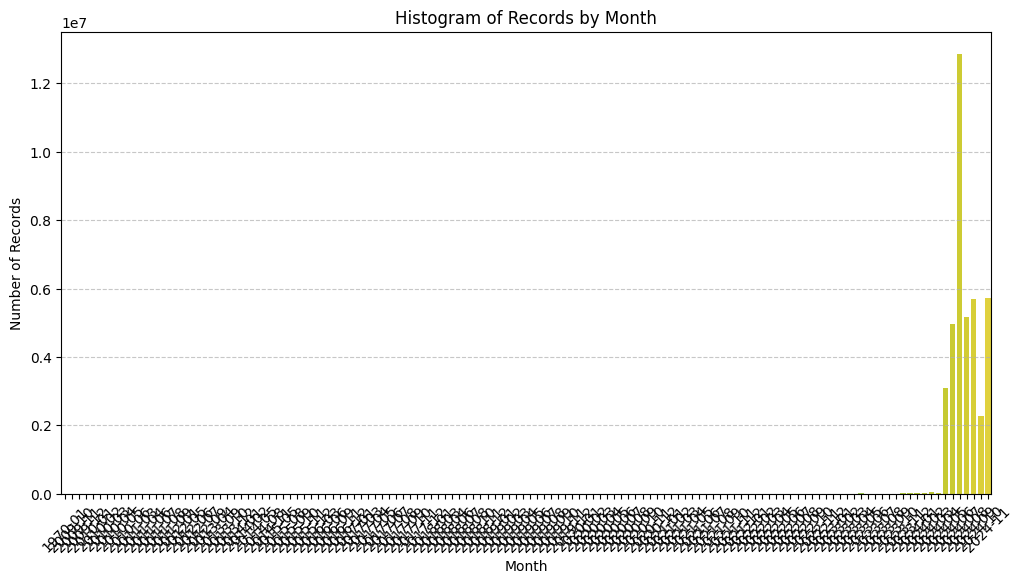

In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import tqdm

import warnings
# Suppress only DtypeWarning
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

# Dictionary to store counts
type_counts = defaultdict(int)
parts = os.listdir(root_dir)

pbar = tqdm.tqdm(parts)
for part in pbar:
    files = glob.glob(os.path.join(root_dir,part,"*.csv.gz"))
    
    # Iterate through all CSV files
    for file in files:

        # Read the CSV file
        df = pd.read_csv(file,compression='gzip')
        
        counts = df['type'].value_counts()
        for category, count in counts.items():
            type_counts[category] += count
        
        # Delete the file after reading
        del df 
        pbar.set_description("Completed for part "+file)

# Convert dictionary to DataFrame
df_counts = pd.DataFrame(list(date_counts.items()), columns=['date', 'count'])

# Extract year-month
df_counts['month'] = df_counts['date'].astype(str).str[:7]  # YYYY-MM format

# Aggregate counts by month
month_counts = df_counts.groupby('month')['count'].sum()

# Plot histogram
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of Records")
plt.title("Histogram of Records by Month")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [39]:
type_counts

defaultdict(int,
            {'tweet-': 40072633,
             'ad_tweet': 453299,
             ' https://t.co/5HJjozCxpi': 1})

In [35]:
df_counts.sort_values(by='date')

,date,count
15,1970-01-01,8
608,2009-10-13,2
610,2009-10-15,2
609,2009-10-22,2
632,2009-10-23,1
...,...,...
1731,2024-11-26,280598
24,2024-11-27,345924
1737,2024-11-28,276506
1699,2024-11-29,228800


In [37]:
# Filter records before May 2024
df_before_may = df_counts[df_counts['date'] < "2023-05-01"]

# Sum the counts
num_records_before_may = df_before_may['count'].sum()

print("Number of records before May 2024:", num_records_before_may)


Number of records before May 2024: 39507


/tmp/SLURM_397155/ipykernel_2815647/363304591.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month'] = df_filtered['date'].dt.to_period("M")  # YYYY-MM format
/tmp/SLURM_397155/ipykernel_2815647/363304591.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index, y=month_counts.values, palette=colors)


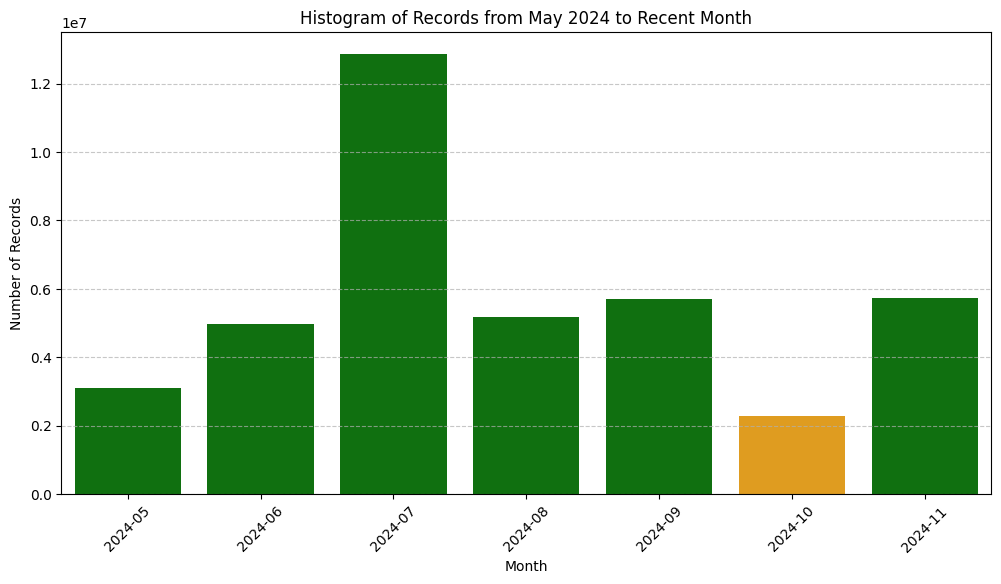

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert dictionary to DataFrame
df_counts = pd.DataFrame(list(date_counts.items()), columns=['date', 'count'])

# Ensure 'date' is a datetime object
df_counts['date'] = pd.to_datetime(df_counts['date'])

# Filter for data from May 2024 onward
df_filtered = df_counts[df_counts['date'] >= "2024-05-01"]

# Extract year-month
df_filtered['month'] = df_filtered['date'].dt.to_period("M")  # YYYY-MM format

# Aggregate counts by month
month_counts = df_filtered.groupby('month')['count'].sum()

# Convert index back to string for plotting
month_counts.index = month_counts.index.astype(str)

# Set colors - highlight "2024-10" with a different color
colors = ["orange" if month == "2024-10" else "green" for month in month_counts.index]

# Plot histogram for May 2024 to the most recent month
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette=colors)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Records from May 2024 to Recent Month")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
